По мотивам OzonMasters и https://github.com/henrhoi/realnvp-pytorch/blob/master/realnvp_3d.py

In [1]:
import sys
import logging

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from torch.utils.data import DataLoader

In [5]:
import torchvision
from torchvision import datasets
from torchvision.utils import make_grid

In [6]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
)

# Data Load

Поток работает с непрерывними данными. Если данные дискретные, нужна деквантизация

In [7]:
train_dataset = datasets.MNIST(
    root='data',
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: torch.round(x)),
    ]),
    download=True,
)

In [8]:
test_dataset = datasets.MNIST(
    root='data',
    train=False,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: torch.round(x)),
    ]),
    download=False,
)

In [9]:
len(train_dataset), len(test_dataset)

(60000, 10000)

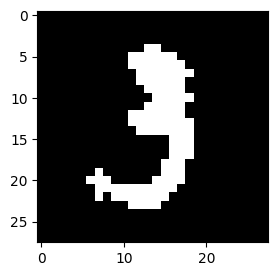

In [10]:
plt.figure(figsize=(3,3))
plt.imshow(train_dataset[10][0].detach().cpu().numpy()[0], cmap='gray')

In [11]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    drop_last=True,
    num_workers=4,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
for batch in train_loader:
    data, labels = batch
    print(data.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# Model

In [13]:
class WeightNormConv2d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        padding: int
    ):
        super(WeightNormConv2d, self).__init__()
        self.conv = nn.utils.weight_norm(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding=padding
            )
        )

    def forward(self, x):
        return self.conv(x)

In [14]:
class ResidualBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
    ):
        super(ResidualBlock, self).__init__()

        self.model = nn.Sequential(
            WeightNormConv2d(in_channels, out_channels, kernel_size=1, padding=0),
            nn.ReLU(),
            WeightNormConv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            WeightNormConv2d(in_channels, out_channels, kernel_size=1, padding=0),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x) + x

class ResidualModel(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        n_filters: int = 64,
        n_blocks: int = 6
    ):
        super(ResidualModel, self).__init__()
        model = [
            WeightNormConv2d(in_channels, n_filters, kernel_size=3, padding=1),
            nn.ReLU(),
        ]
        model += [
            ResidualBlock(n_filters, n_filters) for _ in range(n_blocks)
        ]
        model += [
            WeightNormConv2d(n_filters, out_channels, kernel_size=3, padding=1),
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [15]:
class AffineCheckerboardCouplingLayer(nn.Module):
    def __init__(
        self,
        parity_type: bool,
        input_shape: tuple,
        in_channels: int = 3,
        n_filters: int = 32,
        n_blocks: int = 4
    ):
        super(AffineCheckerboardCouplingLayer, self).__init__()
        self.input_shape = input_shape
        self.parity_type = parity_type
        self.mask = self.build_mask(self.input_shape, self.parity_type).to(device)

        self.scale = nn.Parameter(torch.ones(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)

        out_channels = 2 * in_channels  # for s(.) and t(.)
        self.resnet = ResidualModel(in_channels, out_channels, n_filters, n_blocks)

    @staticmethod
    def build_mask(input_shape, parity_type) -> torch.Tensor:
        mask = np.indices(input_shape).sum(axis=0) % 2
        parity_mask = (parity_type ^ mask).reshape(1, 1, *input_shape)
        return torch.tensor(parity_mask, dtype=torch.float32)

    def forward(self, x: torch.Tensor):
        batch_size, n_channels, _, _ = x.shape
        mask = self.mask.repeat(batch_size, 1, 1, 1)

        s, t = self.resnet(x*mask).chunk(2, dim=1)

        s = self.scale * torch.tanh(s) + self.scale_shift
        t = t * (1.0 - mask)
        s = s * (1.0 - mask)

        # apply forward transform
        z = x * s.exp() + t
        return z, s

    def backward(self, z: torch.Tensor):
        batch_size, n_channels, _, _ = z.shape
        mask = self.mask.repeat(batch_size, 1, 1, 1)

        s, t = self.resnet(z*mask).chunk(2, dim=1)

        s = self.scale * torch.tanh(s) + self.scale_shift
        t = t * (1.0 - mask)
        s = s * (1.0 - mask)

        # apply inverse transform
        x = (z - t) * torch.exp(-s)
        return x

In [16]:
class AffineChannelCouplingLayer(nn.Module):
    def __init__(
        self,
        parity_type: bool,
        in_channels: int = 12,
        n_filters: int = 32,
        n_blocks: int = 4
    ):
        super(AffineChannelCouplingLayer, self).__init__()
        self.parity_type = parity_type
        self.scale = nn.Parameter(torch.ones(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)

        # define resnet that will output s() and t()
        self.resnet = ResidualModel(in_channels, 2 * in_channels, n_filters, n_blocks)


    def forward(self, x: torch.Tensor):
        N, C, H, W = x.shape

        # 1) split x to two equal parts by channel dimension (dim=1)
        # 2) apply resnet to one of this part
        # 3) split resnet output to get s and t

        first_channels, second_channels = torch.chunk(x, 2, dim=1)

        if self.parity_type:
            s, t = self.resnet(first_channels).chunk(2, dim=1)
            s = self.scale * torch.tanh(s) + self.scale_shift

            z = torch.cat([first_channels, second_channels * s.exp() + t], dim=1)
            jacobian = torch.cat([torch.zeros_like(s), s], dim=1)
        else:
            s, t = self.resnet(second_channels).chunk(2, dim=1)
            s = self.scale * torch.tanh(s) + self.scale_shift

            z = torch.cat([first_channels * s.exp() + t, second_channels], dim=1)
            jacobian = torch.cat([s, torch.zeros_like(s)], dim=1)

        return z, jacobian

    def backward(self, z: torch.Tensor):
        N, C, H, W = z.shape

        # 1) split x to two equal parts by channel dimension (dim=1)
        # 2) apply resnet to one of this part
        # 3) split resnet output to get s and t

        first_channels, second_channels = torch.chunk(z, 2, dim=1)

        if self.parity_type:
            s, t = self.resnet(first_channels).chunk(2, dim=1)
            s = self.scale * torch.tanh(s) + self.scale_shift

            x = torch.cat([first_channels, (second_channels - t) * torch.exp(-s)], dim=1)
        else:
            s, t = self.resnet(second_channels).chunk(2, dim=1)
            s = self.scale * torch.tanh(s) + self.scale_shift

            x = torch.cat([(first_channels - t) * torch.exp(-s), second_channels], dim=1)

        return x

In [17]:
class ActNormLayer(nn.Module):
    def __init__(
        self,
        n_channels: int
    ):
        super(ActNormLayer, self).__init__()
        self.log_std = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.mean = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.initialized = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if not self.initialized:
            with torch.no_grad():
                x_mean = x.mean(dim=[0, 2, 3], keepdim=True)
                variance = ((x - x_mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
                log_std = torch.log(torch.sqrt(variance))

                self.mean.data.copy_(-x_mean.data)
                self.log_std.data.copy_(-log_std.data)

            self.initialized = True
        return (x + self.mean) * torch.exp(self.log_std), self.log_std

    def backward(self, z: torch.Tensor) -> torch.Tensor:
        return z * torch.exp(-self.log_std) - self.mean

Проблема, которую нужно здесь рассмотреть, — это ограниченность области изображений. Для модели более естественно подходить к данным из диапазона $(-\infty, +\infty)$.

Самый естественный способ преобразовать диапазон $(-\infty, +\infty)$ в $[0, 1]$ — применить сигмоиду. Но здесь понадобится обратное преобразование из диапазона [0, 1] (это нормализованные деквантованные изображения) в $(-\infty, +\infty)$. Поэтому нужно применить обратную сигмоидную функцию. Эта функция называется логит:

$$
    \text{logit}(x) = \log \left( \frac{x}{1 - x} \right) = \log (x) - \log (1 - x).
$$

Чтобы сделать преобразование стабильным, общепринятой практикой является сначала преобразовать диапазон [0, 1] в $[\alpha, 1 - \alpha]$:

$$
    \text{logit}(x) = \log (y) - \log (1 - y), \quad \text{where } y = \alpha + (1 - 2 * \alpha) * x.
$$

Также для этого преобразования понадобится логарифм якобиана.

In [18]:
def dequantize(x: torch.Tensor, nbins: int = 256) -> torch.Tensor:
    return (
        x * (nbins - 1) + torch.distributions.Uniform(0.0, 1.0).sample(x.shape).to(x.device)
    ) / nbins

In [19]:
class LogitTransform(nn.Module):
    """
    Transformation [0, 1] -> [alpha, 1 - alpha] -> [-inf, +inf]
    """
    def __init__(
        self,
        alpha: float = 0.05,
        dequantize: bool = True,
        nbins: int = 256
    ):
        super(LogitTransform, self).__init__()
        self.alpha = alpha
        self.dequantize = dequantize
        self.nbins = nbins

    def forward(self, x: torch.Tensor):
        if self.dequantize:
            x = dequantize(x, nbins=self.nbins)
        # 1) scale the data to [alpha, 1 - alpha] range -> x_scaled
        # 2) apply logit operation -> x
        x_scaled = self.alpha + (1 - 2 * self.alpha) * x
        x = torch.log(x_scaled) - torch.log(1.0 - x_scaled)

        # dF(y)/dx = dF(y)/dx * dy/dx = (1 - 2 * alpha) / (y * (1 - y))
        # F(y) = log(y) - log(1 - y)
        # y = alpha + (1 - 2 * alpha) * x
        log_det = - torch.log(x_scaled) - torch.log(1.0 - x_scaled) + torch.log(torch.tensor(1 - 2 * self.alpha))

        return x, log_det

    def backward(self, z: torch.Tensor) -> torch.Tensor:
        x = (torch.sigmoid(z) - self.alpha) / (1 - 2 * self.alpha)
        # log_det = - x - 2 * F.softplus(-x) - torch.log(torch.tensor(1 - 2 *  self.alpha))
        return x

In [20]:
class Squeeze(nn.Module):
    def __init__(self):
        super(Squeeze, self).__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        N, C, H, W = x.shape
        x = x.reshape(N, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        return x.reshape(N, 4 * C, H // 2, W // 2)

    def backward(self, z: torch.Tensor) -> torch.Tensor:
        return Unsqueeze()(z)

In [21]:
class Unsqueeze(nn.Module):
    def __init__(self):
        super(Unsqueeze, self).__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        N, C, H, W = x.shape
        x = x.reshape(N, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
        return x.reshape(N, C // 4, H * 2, W * 2)

    def backward(self, z: torch.Tensor) -> torch.Tensor:
        return Squeeze()(z)

In [22]:
class RealNVP(nn.Module):
    def __init__(self, input_shape):
        super(RealNVP, self).__init__()
        C, H, W = input_shape

        modules = [[LogitTransform(nbins=2, dequantize=True)]]
        modules += [[AffineCheckerboardCouplingLayer(
            input_shape=(H, W),
            parity_type=(i % 2) == 0,
            in_channels=C,
        ), ActNormLayer(C)] for i in range(4)]
        modules.append([Squeeze()])
        modules += [[AffineChannelCouplingLayer(
            in_channels=2 * C,
            parity_type=(i % 2) == 0,
        ), ActNormLayer(4 * C)] for i in range(3)]
        modules.append([Unsqueeze()])
        modules += [[AffineCheckerboardCouplingLayer(
            input_shape=(H, W),
            parity_type=(i % 2) == 0,
            in_channels=C,
        ), ActNormLayer(C)] for i in range(3)]

        modules = [layer for layer_types in modules for layer in layer_types]
        self.model = nn.Sequential(*modules)

    def forward(self, x: torch.Tensor) -> tuple:
        z = x
        log_det = torch.zeros_like(x)

        for layer in self.model:
            if isinstance(layer, (Squeeze, Unsqueeze)):
                z = layer(z)
                log_det = layer(log_det)
            else:
                z, delta_log_det = layer(z)
                log_det += delta_log_det

        return z, log_det

    def backward(self, z: torch.Tensor) -> torch.Tensor:
        x = z
        for layer in reversed(self.model):
            x = layer.backward(x)

        return x

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
model = RealNVP(
    input_shape=(1, 28, 28),
)

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [25]:
def count_parameters(model: nn.Module):
    """Количество обучаемых параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [26]:
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 470,222 trainable parameters


# Train

In [27]:
def train(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str,
    clip: float = 3.0,
    train_history=None,
    valid_history=None,
):
    epoch_loss = 0
    history = []

    model.train()
    for i, batch in enumerate(tqdm(train_loader)):
        data = batch[0].to(device)
        labels = batch[1].to(device)

        z, log_det = model(data)
        loss = criterion(data, z, log_det)

        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        history.append(loss.cpu().data.numpy())
        if ((i + 1) % 10 == 0) or (i == (len(train_loader) - 1)):
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

            clear_output(True)
            ax[0].plot(history, label="train loss")
            ax[0].set_xlabel("Batch")
            ax[0].set_title("Train loss")
            if train_history is not None:
                ax[1].plot(train_history, label="general train history")
                ax[1].set_xlabel("Epoch")
            if valid_history is not None:
                ax[1].plot(valid_history, label="general valid history")
            plt.legend()

            plt.show()
        i += 1

    return epoch_loss / len(train_loader), loss.item()

In [28]:
def validate(
    model: nn.Module, valid_loader: DataLoader, criterion: nn.Module, device: str
):

    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            data = batch[0].to(device)
            labels = batch[1].to(device)

            z, log_det = model(data)
            loss = criterion(data, z, log_det)

            epoch_loss += loss.item()

    return epoch_loss / len(valid_loader)

In [29]:
def fit(
    model: nn.Module,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    criterion,
    optimizer,
    start_epoch: int,
    end_epoch: int,
    clip: float = 3.0,
):

    train_losses = []
    valid_losses = []

    for epoch in range(start_epoch, end_epoch):
        train_loss, last_batch_loss = train(
            model,
            train_loader,
            criterion,
            optimizer,
            device,
            clip,
            train_losses,
            valid_losses,
        )
        valid_loss = validate(model, valid_loader, criterion, device)
        print(
            f"Epoch: {epoch}, Training Loss: {train_loss}, Valid Loss: {valid_loss}"
        )

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    return train_losses, valid_losses

In [30]:
model.to(device)
print()

In [31]:
class NLLLoss(nn.Module):
    def __init__(self):
        super(NLLLoss, self).__init__()
        self.prior = torch.distributions.normal.Normal(loc=.0, scale=1.)

    def forward(
        self,
        batch: torch.Tensor,
        z: torch.Tensor,
        log_det: torch.Tensor,
    ):
        N, C, H, W = batch.shape

        log_pz = self.prior.log_prob(z).to(device)
        log_p_theta = torch.sum((log_pz + log_det).view(N, -1), dim=1) / (C * H * W)
        return - torch.mean(log_p_theta)

In [32]:
start_epoch = 0
end_epoch = 10
optimizer = torch.optim.Adam(model.parameters())
criterion = NLLLoss()

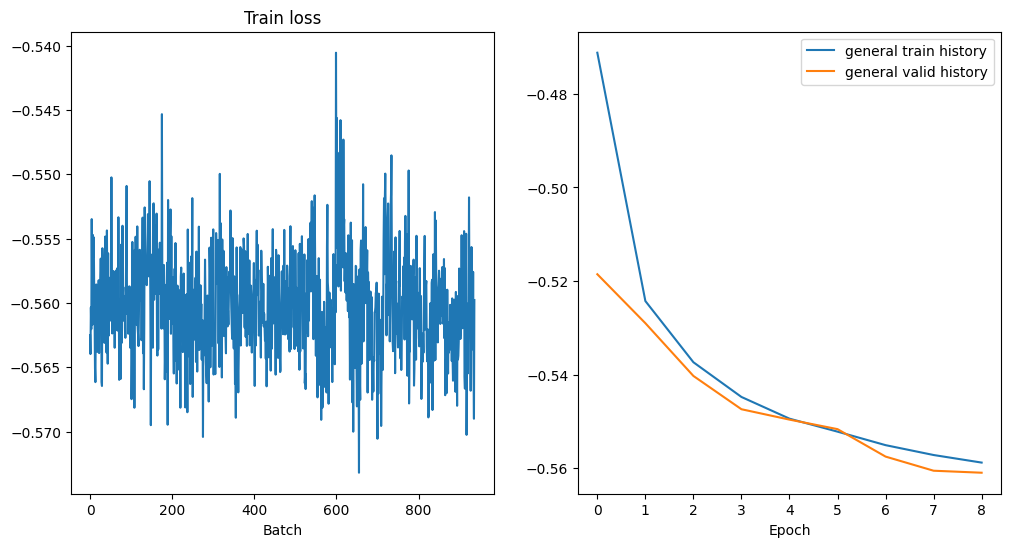

100%|██████████| 156/156 [00:07<00:00, 20.82it/s]

Epoch: 9, Training Loss: -0.5601764853761443, Valid Loss: -0.5586506441617624


In [33]:
train_losses, valid_losses = fit(
    model=model,
    train_loader=train_loader,
    valid_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    start_epoch=start_epoch,
    end_epoch=end_epoch,
)

In [34]:
def sample(num_samples, nbins: int = 2):
    z = criterion.prior.sample([num_samples, 1, 28, 28]).to(device)
    samples = model.backward(z)
    samples = samples.cpu().detach().numpy()
    samples = np.floor(np.clip(samples * nbins, 0.0, nbins - 1)) / (nbins - 1)
    return samples

In [35]:
def show_samples(samples, title, figsize=None, nrow=None):
    if isinstance(samples, np.ndarray):
        samples = torch.FloatTensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow, pad_value=1, padding=1)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.show()

In [36]:
model.eval()
print()

In [37]:
samples = sample(16)

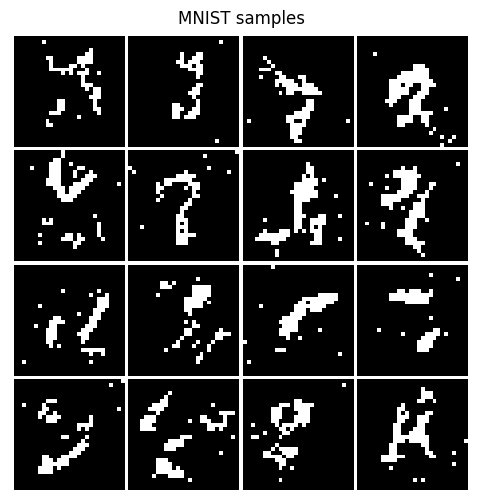

In [38]:
show_samples(samples, title='MNIST samples', nrow=4)